<a href="https://colab.research.google.com/github/DrAlexSanz/NLP-SPEC-C4/blob/main/W1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1: Neural Machine Translation
Welcome to the first assignment of Course 4. Here, you will build an English-to-German neural machine translation (NMT) model using Long Short-Term Memory (LSTM) networks with attention. Machine translation is an important task in natural language processing and could be useful not only for translating one language to another but also for word sense disambiguation (e.g. determining whether the word "bank" refers to the financial bank, or the land alongside a river). Implementing this using just a Recurrent Neural Network (RNN) with LSTMs can work for short to medium length sentences but can result in vanishing gradients for very long sequences. To solve this, you will be adding an attention mechanism to allow the decoder to access all relevant parts of the input sentence regardless of its length. By completing this assignment, you will:

* learn how to preprocess your training and evaluation data
* implement an encoder-decoder system with attention
* understand how attention works
* build the NMT model from scratch using Trax
* generate translations using greedy and Minimum Bayes Risk (MBR) decoding

In [1]:
from termcolor import colored
import random
import numpy as np
!pip install trax
import trax
from trax import layers as tl
from trax.fastmath import numpy as fastnp
from trax.supervised import training

!pip list | grep trax

     |████████████████████████████████| 522kB 21.6MB/s 
     |████████████████████████████████| 215kB 31.7MB/s 
     |████████████████████████████████| 3.4MB 34.8MB/s 
     |████████████████████████████████| 3.7MB 49.0MB/s 
     |████████████████████████████████| 1.5MB 47.6MB/s 
     |████████████████████████████████| 368kB 52.5MB/s 
     |████████████████████████████████| 71kB 11.7MB/s 
     |████████████████████████████████| 1.2MB 45.8MB/s 
     |████████████████████████████████| 890kB 33.2MB/s 
     |████████████████████████████████| 2.9MB 44.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=02e863448c445e0b0b3bcc9d3f4acf5f8e64c2daa2bd99aae8743c50955b186c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
trax                          1.3.7                


## Part 1: Data Preparation

## 1.1 Importing the Data
We will first start by importing the packages we will use in this assignment. As in the previous course of this specialization, we will use the Trax library created and maintained by the Google Brain team to do most of the heavy lifting. It provides submodules to fetch and process the datasets, as well as build and train the model.

Next, we will import the dataset we will use to train the model. To meet the storage constraints in this lab environment, we will just use a small dataset from Opus, a growing collection of translated texts from the web. Particularly, we will get an English to German translation subset specified as opus/medical which has medical related texts. If storage is not an issue, you can opt to get a larger corpus such as the English to German translation dataset from ParaCrawl, a large multi-lingual translation dataset created by the European Union. Both of these datasets are available via Tensorflow Datasets (TFDS) and you can browse through the other available datasets here. We have downloaded the data for you in the data/ directory of your workspace. As you'll see below, you can easily access this dataset from TFDS with trax.data.TFDS. The result is a python generator function yielding tuples. Use the keys argument to select what appears at which position in the tuple. For example, keys=('en', 'de') below will return pairs as (English sentence, German sentence).

In [2]:
train_stream_fn = trax.data.TFDS('opus/medical',
                                 data_dir='./data/',
                                 keys=('en', 'de'),
                                 eval_holdout_size=0.01, # 1% for eval
                                 train=True)

# Get generator function for the eval set
eval_stream_fn = trax.data.TFDS('opus/medical',
                                data_dir='./data/',
                                keys=('en', 'de'),
                                eval_holdout_size=0.01, # 1% for eval
                                train=False)

Dataset opus downloaded and prepared to ./data/opus/medical/0.1.0. Subsequent calls will reuse this data.


Notice that TFDS returns a generator function, not a generator. This is because in Python, you cannot reset generators so you cannot go back to a previously yielded value. During deep learning training, you use Stochastic Gradient Descent and don't actually need to go back -- but it is sometimes good to be able to do that, and that's where the functions come in. It is actually very common to use generator functions in Python -- e.g., zip is a generator function. You can read more about Python generators to understand why we use them. Let's print a a sample pair from our train and eval data. Notice that the raw ouput is represented in bytes (denoted by the b' prefix) and these will be converted to strings internally in the next steps.

In [3]:
train_stream = train_stream_fn()
print(colored('train data (en, de) tuple:', 'red'), next(train_stream))
print()

eval_stream = eval_stream_fn()
print(colored('eval data (en, de) tuple:', 'red'), next(eval_stream))

train data (en, de) tuple: (b'During treatment with olanzapine, adolescents gained significantly more weight compared with adults.\n', b'W\xc3\xa4hrend der Behandlung mit Olanzapin nahmen die Jugendlichen im Vergleich zu Erwachsenen signifikant mehr Gewicht zu.\n')

eval data (en, de) tuple: (b'Lutropin alfa Subcutaneous use.\n', b'Pulver zur Injektion Lutropin alfa Subkutane Anwendung\n')


## Get all the files from Github and arrange all the dirs

In [26]:
!git clone https://github.com/DrAlexSanz/NLP-SPEC-C4.git
!cp "NLP-SPEC-C4/W1/data/ende_32k.subword" "data"
!cp "NLP-SPEC-C4/W1/w1_unittest.py" "./"
!rm -rf "NLP-SPEC-C4"


Cloning into 'NLP-SPEC-C4'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 35 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (35/35), done.


## 1.2 Tokenization and Formatting
Now that we have imported our corpus, we will be preprocessing the sentences into a format that our model can accept. This will be composed of several steps:

**Tokenizing the sentences using subword representations:** As you've learned in the earlier courses of this specialization, we want to represent each sentence as an array of integers instead of strings. For our application, we will use subword representations to tokenize our sentences. This is a common technique to avoid out-of-vocabulary words by allowing parts of words to be represented separately. For example, instead of having separate entries in your vocabulary for --"fear", "fearless", "fearsome", "some", and "less"--, you can simply store --"fear", "some", and "less"-- then allow your tokenizer to combine these subwords when needed. This allows it to be more flexible so you won't have to save uncommon words explicitly in your vocabulary (e.g. stylebender, nonce, etc). Tokenizing is done with the trax.data.Tokenize() command and we have provided you the combined subword vocabulary for English and German (i.e. ende_32k.subword) saved in the data directory. Feel free to open this file to see how the subwords look like.

In [5]:
# global variables that state the filename and directory of the vocabulary file
VOCAB_FILE = 'ende_32k.subword'
VOCAB_DIR = 'data/'

tokenized_train_stream = trax.data.Tokenize(vocab_file = VOCAB_FILE, vocab_dir = VOCAB_DIR)(train_stream)
tokenized_eval_stream = trax.data.Tokenize(vocab_file = VOCAB_FILE, vocab_dir = VOCAB_DIR)(eval_stream)

**Append an end-of-sentence token to each sentence:** We will assign a token (i.e. in this case 1) to mark the end of a sentence. This will be useful in inference/prediction so we'll know that the model has completed the translation.

In [6]:
EOS = 1 # It's already an int

def append_eos(stream):
    for inputs, targets in stream:
        input_with_eos = list(inputs) + [EOS]
        target_with_eos = list(targets) + [EOS]
        yield np.array(input_with_eos), np.array(target_with_eos)

In [7]:
tokenized_train_stream = append_eos(tokenized_train_stream)
tokenized_eval_stream = append_eos(tokenized_eval_stream)

Filter long sentences: We will place a limit on the number of tokens per sentence to ensure we won't run out of memory. This is done with the trax.data.FilterByLength() method and you can see its syntax below.

In [8]:
# Filter long sentences to not run out of memory.
# length_keys=[0, 1] means we filter both English and German sentences, so
# both won't be longer that 256 tokens for training / 512 for eval.

filtered_train_stream = trax.data.FilterByLength(max_length = 256, length_keys = [0, 1])(tokenized_train_stream)

filtered_eval_stream = trax.data.FilterByLength(max_length = 512, length_keys = [0, 1])(tokenized_eval_stream)

In [9]:
# print a sample input-target pair of tokenized sentences
train_input, train_target = next(filtered_train_stream)
print(colored(f'Single tokenized example input:', 'red' ), train_input)
print(colored(f'Single tokenized example target:', 'red'), train_target)

Single tokenized example input: [ 2326 13139   605  9214  3337  7932  1047    15  1489  4318  6304   331
  2326 31329 11722     5 16276 14026  2801 11765 14446   363 21981   219
 26382   500 30650  4729   992     1]
Single tokenized example target: [ 2326 13139   605  9214  3337  7932  1047    15  1489  4318  6304   331
  2326 31329 11722     5 16276 14026  2801 11765 14446   363 21981   219
 26382   500 30650  4729   992     1]


## 1.3 Tokenize & detokenize helper functions
Given any data set, you have to be able to map words to their indices, and indices to their words. The inputs and outputs to your trax models are usually tensors of numbers where each number corresponds to a word. If you were to process your data manually, you would have to make use of the following:

* word2Ind: a dictionary mapping the word to its index.
* ind2Word: a dictionary mapping the index to its word.
* word2Count: a dictionary mapping the word to the number of times it appears.
* num_words: total number of words that have appeared.

Since you have already implemented these in previous assignments of the specialization, we will provide you with helper functions that will do this for you. Run the cell below to get the following functions:

* tokenize(): converts a text sentence to its corresponding token list (i.e. list of indices). Also converts words to subwords (parts of words).
* detokenize(): converts a token list to its corresponding sentence (i.e. string).

In [10]:
def tokenize(input_str, vocab_file = None, vocab_dir = None):
    """
    Take a string (sentence) and return all the tokens as integers.
    Input:
      input_str: a string with words.
      vocab_file: filename of the vocab file
      vocab_dir: path to the vocab file

    Output:
      np.array with the ints of the words
    """

    EOS = 1

    # The trax.data.tokenize method takes and ouptuts a stram. We make a 1 element string with next()
    # And don't forget to use iter()!!

    inputs = next(trax.data.tokenize(iter([input_str]), vocab_type = "subword", vocab_file = vocab_file, vocab_dir = vocab_dir))

    inputs =  list(inputs) + [EOS]

    batch_inputs = np.reshape(np.array(inputs), [1, -1])

    return batch_inputs


def detokenize(integers, vocab_file = None, vocab_dir = None):
    """
    Decodes an array of ints to a string (sentence)

    Input:
      integers: The list of tokenized words (np.array)
    Output:
      a string with the sentence detokenized    
    """

    integers = list(np.squeeze(integers))

    EOS = 1

    if EOS in integers:
        integers = integers[:integers.index(EOS)]

    return trax.data.detokenize(integers, vocab_type = "subword", vocab_file = vocab_file, vocab_dir = vocab_dir)

In [11]:
# Test
# From before:
# VOCAB_FILE = 'ende_32k.subword'
# VOCAB_DIR = 'data/'

# Detokenize an input-target pair of tokenized sentences
print(colored(f'Single detokenized example input:', 'red'), detokenize(train_input, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR))
print(colored(f'Single detokenized example target:', 'red'), detokenize(train_target, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR))
print()

# Tokenize and detokenize a word that is not explicitly saved in the vocabulary file.
# See how it combines the subwords -- 'hell' and 'o'-- to form the word 'hello'.
print(colored(f"tokenize('hello'): ", 'green'), tokenize('hello', vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR))
print(colored(f"detokenize([17332, 140, 1]): ", 'green'), detokenize([17332, 140, 1], vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR))

Single detokenized example input: Sverige BRISTOL-MYERS SQUIBB AB Tel: + 46 8 704 71 00

Single detokenized example target: Sverige BRISTOL-MYERS SQUIBB AB Tel: + 46 8 704 71 00


tokenize('hello'):  [[17332   140     1]]
detokenize([17332, 140, 1]):  hello


# 1.4 Bucketing
Bucketing the tokenized sentences is an important technique used to speed up training in NLP. Here is a nice article describing it in detail but the gist is very simple. Our inputs have variable lengths and you want to make these the same when batching groups of sentences together. One way to do that is to pad each sentence to the length of the longest sentence in the dataset. This might lead to some wasted computation though. For example, if there are multiple short sentences with just two tokens, do we want to pad these when the longest sentence is composed of a 100 tokens? Instead of padding with 0s to the maximum length of a sentence each time, we can group our tokenized sentences by length and bucket, as on this image (from the article above):

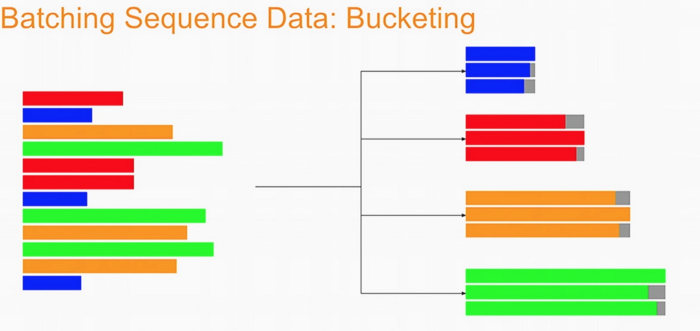

We batch the sentences with similar length together (e.g. the blue sentences in the image above) and only add minimal padding to make them have equal length (usually up to the nearest power of two). This allows to waste less computation when processing padded sequences. In Trax, it is implemented in the bucket_by_length function.

In [13]:
# Bucketing to create streams of batches.

# Buckets are defined in terms of boundaries and batch sizes.
# Batch_sizes[i] determines the batch size for items with length < boundaries[i]
# So below, we'll take a batch of 256 sentences of length < 8, 128 if length is
# between 8 and 16, and so on -- and only 2 if length is over 512.
boundaries =  [8,   16,  32, 64, 128, 256, 512]
batch_sizes = [256, 128, 64, 32, 16,    8,   4,  2]

# Create generator

train_batch_stream = trax.data.BucketByLength(boundaries,
                                              batch_sizes,
                                              length_keys = [0, 1],
                                              )(filtered_train_stream)

eval_batch_stream = trax.data.BucketByLength(boundaries,
                                             batch_sizes,
                                             length_keys = [0, 1],
                                             )(filtered_eval_stream)

# Mask the padding 0's

train_batch_stream = trax.data.AddLossWeights(id_to_mask = 0)(train_batch_stream)
eval_batch_stream = trax.data.AddLossWeights(id_to_mask = 0)(eval_batch_stream)



# 1.5 Exploring the data
We will now be displaying some of our data. You will see that the functions defined above (i.e. tokenize() and detokenize()) do the same things you have been doing again and again throughout the specialization. We gave these so you can focus more on building the model from scratch. Let us first get the data generator and get one batch of the data.

In [14]:
input_batch, target_batch, mask_batch = next(train_batch_stream)

print("The data type of the train batch is", type(input_batch))
print("The data type of the mask batch is", type(mask_batch)) # If they are not np arrays I have a problem.

# And also the shape of these things

print("The shape of input batch is:", input_batch.shape)
print("The shape of the target batch is:", target_batch.shape)
print("The shape of the mask batch is:", mask_batch.shape)

The data type of the train batch is <class 'numpy.ndarray'>
The data type of the mask batch is <class 'numpy.ndarray'>
The shape of input batch is: (32, 64)
The shape of the target batch is: (32, 64)
The shape of the mask batch is: (32, 64)


The input_batch and target_batch are Numpy arrays consisting of tokenized English sentences and German sentences respectively. These tokens will later be used to produce embedding vectors for each word in the sentence (so the embedding for a sentence will be a matrix). The number of sentences in each batch is usually a power of 2 for optimal computer memory usage.

We can now visually inspect some of the data. You can run the cell below several times to shuffle through the sentences. Just to note, while this is a standard data set that is used widely, it does have some known wrong translations. With that, let's pick a random sentence and print its tokenized representation.

In [18]:
# Pick a random index

index = random.randrange(len(input_batch))

# With the index I'll take an example

print(colored("This is the English sentence: ", "red"), detokenize(input_batch[index], vocab_file = VOCAB_FILE, vocab_dir = VOCAB_DIR))

print(colored("This is the tokenized version of the English sentence: ", "red"), input_batch[index])

print(colored("This is the German translation: ", "red"), detokenize(target_batch[index], vocab_file = VOCAB_FILE, vocab_dir = VOCAB_DIR))

print(colored("This is the tokens for the German translation", "red"), target_batch[index])

This is the English sentence:  Contact your doctor immediately if you become pregnant, think you might be pregnant or are planning to become pregnant while taking LYRICA.

This is the tokenized version of the English sentence:  [21758   139  8937  2626   175    72   449  3678 17363     2   597    72
   616    32  3678 17363    66    31  3376     9   449  3678 17363   459
   981  2474  4318 31318   176  3550 30650  4729   992     1     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
This is the German translation:  Suchen Sie sofort Ihren Arzt auf, wenn Sie während der Behandlung mit LYRICA schwanger werden, glauben schwanger zu sein oder eine Schwangerschaft planen.

This is the tokens for the German translation [15775    23    67  5210  1786 32806    37     2   157    67   408    11
  3544    39  2474  4318 31318   176 16718 16989    58     2  3294 16718


# Part 2: Neural Machine Translation with Attention
Now that you have the data generators and have handled the preprocessing, it is time for you to build the model. You will be implementing a neural machine translation model from scratch with attention.

## 2.1 Attention Overview
The model we will be building uses an encoder-decoder architecture. This Recurrent Neural Network (RNN) will take in a tokenized version of a sentence in its encoder, then passes it on to the decoder for translation. As mentioned in the lectures, just using a a regular sequence-to-sequence model with LSTMs will work effectively for short to medium sentences but will start to degrade for longer ones. You can picture it like the figure below where all of the context of the input sentence is compressed into one vector that is passed into the decoder block. You can see how this will be an issue for very long sentences (e.g. 100 tokens or more) because the context of the first parts of the input will have very little effect on the final vector passed to the decoder.

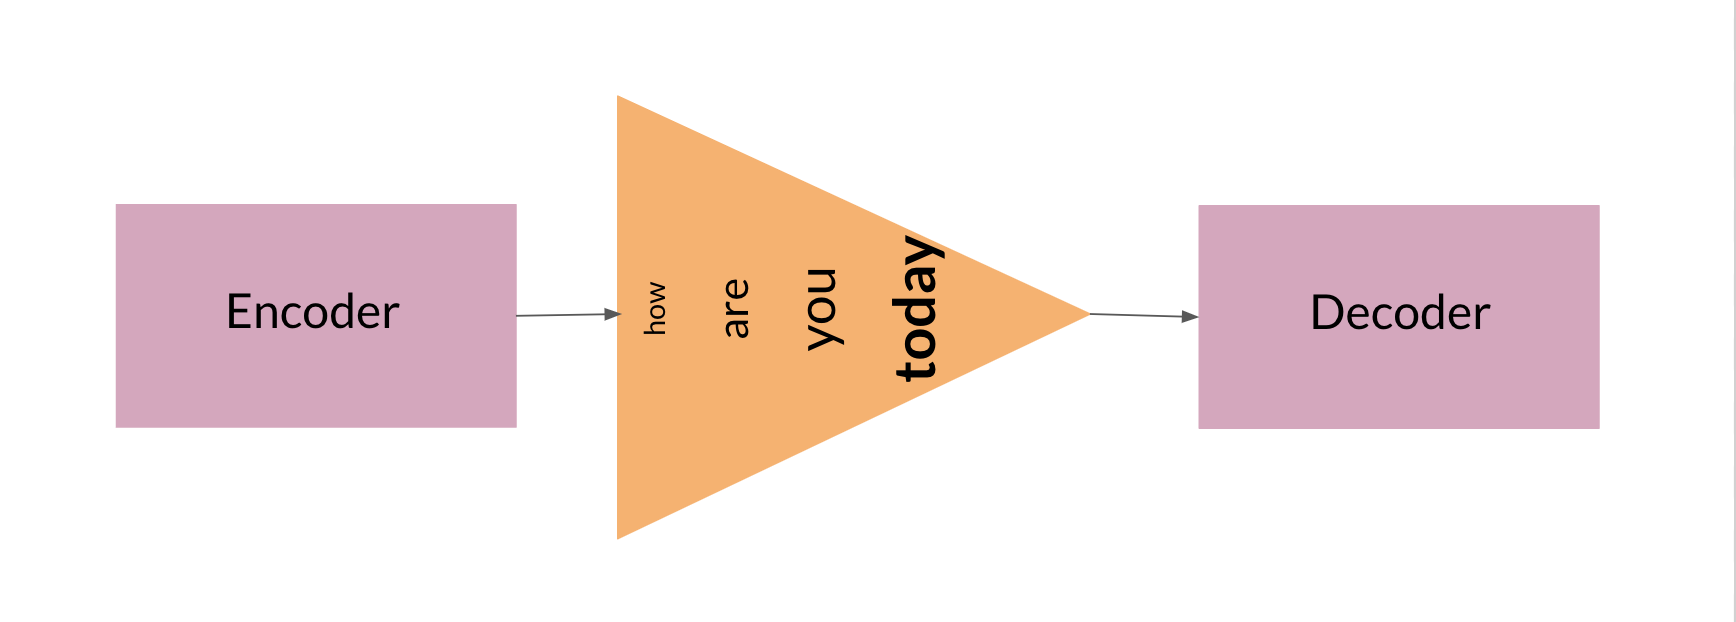

Adding an attention layer to this model avoids this problem by giving the decoder access to all parts of the input sentence. To illustrate, let's just use a 4-word input sentence as shown below. Remember that a hidden state is produced at each timestep of the encoder (represented by the orange rectangles). These are all passed to the attention layer and each are given a score given the current activation (i.e. hidden state) of the decoder. For instance, let's consider the figure below where the first prediction "Wie" is already made. To produce the next prediction, the attention layer will first receive all the encoder hidden states (i.e. orange rectangles) as well as the decoder hidden state when producing the word "Wie" (i.e. first green rectangle). Given these information, it will score each of the encoder hidden states to know which one the decoder should focus on to produce the next word. The result of the model training might have learned that it should align to the second encoder hidden state and subsequently assigns a high probability to the word "geht". If we are using greedy decoding, we will output the said word as the next symbol, then restart the process to produce the next word until we reach an end-of-sentence prediction.



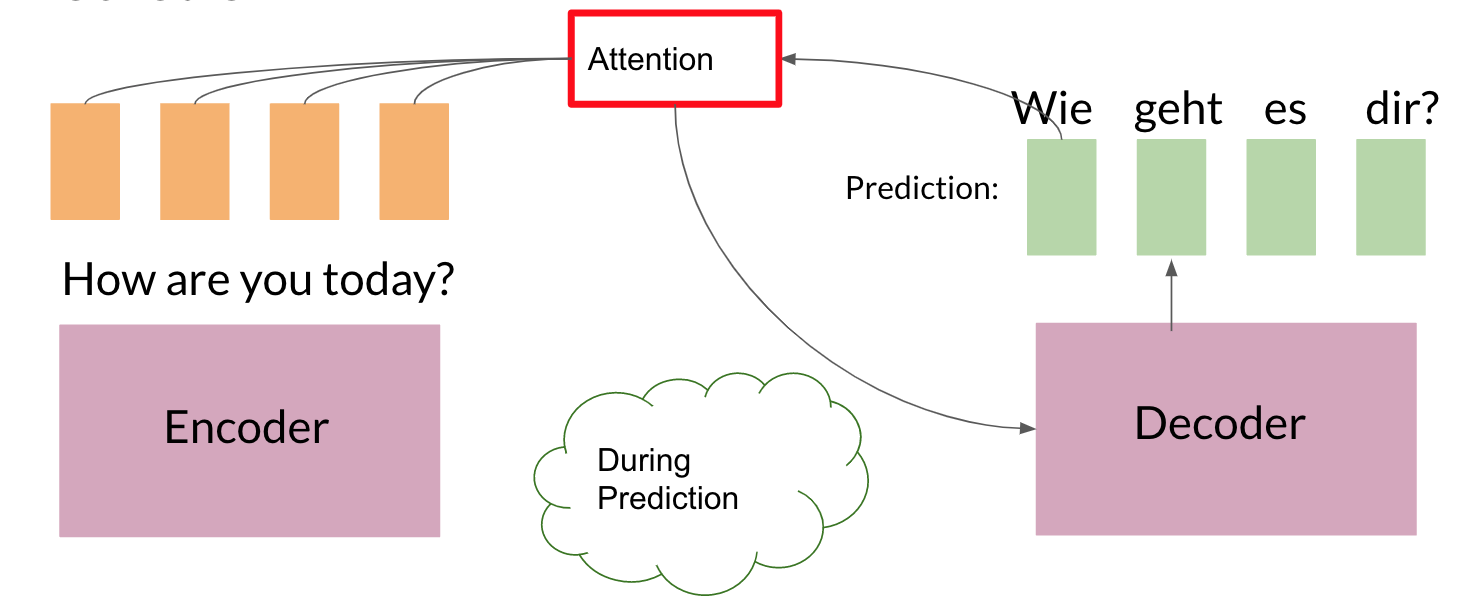

There are different ways to implement attention and the one we'll use for this assignment is the Scaled Dot Product Attention which has the form:

$$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$$
You will dive deeper into this equation in the next week but for now, you can think of it as computing scores using queries (Q) and keys (K), followed by a multiplication of values (V) to get a context vector at a particular timestep of the decoder. This context vector is fed to the decoder RNN to get a set of probabilities for the next predicted word. The division by square root of the keys dimensionality ($\sqrt{d_k}$) is for improving model performance and you'll also learn more about it next week. For our machine translation application, the encoder activations (i.e. encoder hidden states) will be the keys and values, while the decoder activations (i.e. decoder hidden states) will be the queries.

You will see in the upcoming sections that this complex architecture and mechanism can be implemented with just a few lines of code. Let's get started!

## 2.2 Helper functions
We will first implement a few functions that we will use later on. These will be for the input encoder, pre-attention decoder, and preparation of the queries, keys, values, and mask.

### 2.2.1 Input encoder
The input encoder runs on the input tokens, creates its embeddings, and feeds it to an LSTM network. This outputs the activations that will be the keys and values for attention. It is a Serial network which uses:

* tl.Embedding: Converts each token to its vector representation. In this case, it is the the size of the vocabulary by the dimension of the model: tl.Embedding(vocab_size, d_model). vocab_size is the number of entries in the given vocabulary. d_model is the number of elements in the word embedding.

* tl.LSTM: LSTM layer of size d_model. We want to be able to configure how many encoder layers we have so remember to create LSTM layers equal to the number of the n_encoder_layers parameter.

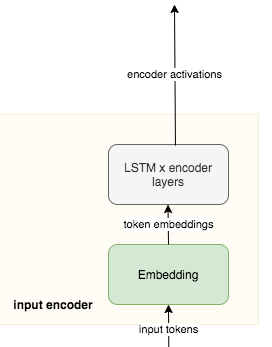

In [19]:
def input_encoder_fn(input_vocab_size, d_model, n_encoder_layers):
    """
    Input encoder. Runs on the input sentence and creates activations that will 
    be keys, queries and values

    Inputs:
      input_vocab_size: vocab size (int)
      d_model: depth of embedding (n units in the LSTM), int
      n_encoder_layers: Number of LSTM layers

    Output:
      tl.Serial: an input encoder
    """

    input_encoder = tl.Serial(
                              tl.Embedding(vocab_size = input_vocab_size,
                                           d_feature = d_model),
                              
                              [tl.LSTM(n_units = d_model) for _ in range(n_encoder_layers)]
                              )
    
    return input_encoder

In [28]:
import w1_unittest
w1_unittest.test_input_encoder_fn(input_encoder_fn)

 All tests passed



2.2.2 Pre-attention decoder
The pre-attention decoder runs on the targets and creates activations that are used as queries in attention. This is a Serial network which is composed of the following:

tl.ShiftRight: This pads a token to the beginning of your target tokens (e.g. [8, 34, 12] shifted right is [0, 8, 34, 12]). This will act like a start-of-sentence token that will be the first input to the decoder. During training, this shift also allows the target tokens to be passed as input to do teacher forcing.

tl.Embedding: Like in the previous function, this converts each token to its vector representation. In this case, it is the the size of the vocabulary by the dimension of the model: tl.Embedding(vocab_size, d_model). vocab_size is the number of entries in the given vocabulary. d_model is the number of elements in the word embedding.

tl.LSTM: LSTM layer of size d_model.

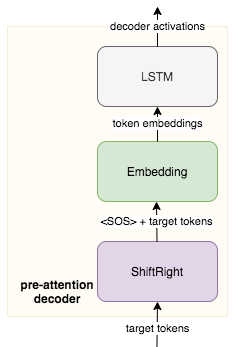